<a href="https://colab.research.google.com/github/KelllyChen/2025-Fall-XAI-Adversarial-Patches/blob/Notebook/AIPI590_XAI_Adversarial_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attacks (Adversarial Patches)
Create an adversarial patch to fool the Torchvision ResNet34 model trained on a small version of ImageNet

# Import packages

In [ ]:
!pip install -q torch torchvision tqdm pillow

import os, random, math, shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets, utils
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet34, ResNet34_Weights

# Download dataset
- Download and unzip tiny imagenet dataset from the official link.

In [ ]:
!wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

# Flatten train folder
- Flatten train set to make it easier for later usage.

In [ ]:
# Flatten train folder
train_root = "tiny-imagenet-200/train"
for wnid in os.listdir(train_root):
    wnid_dir = os.path.join(train_root, wnid)
    imgs_sub = os.path.join(wnid_dir, "images")
    if os.path.isdir(imgs_sub):
        for f in os.listdir(imgs_sub):
            shutil.move(os.path.join(imgs_sub, f), os.path.join(wnid_dir, f))
        os.rmdir(imgs_sub)
print("Train folder flattened")


Train folder flattened


# Train the patch

- This below cell was completed with the assistance of GPT-5. I asked it to give me a structure of how to train a patch and the  I modified some parts on my own to make the patch be more robust.
- The patch can be trained from blank or from an image I uploaded before running the cell. The image I used to train the patch was uploaded on github repo as well.

In [ ]:
# config
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size      = 224
patch_size    = 80
batch_size    = 16
num_epochs    = 3
target_class  = 859
lr            = 1.0
save_dir      = "patch_out_single"
os.makedirs(save_dir, exist_ok=True)

# geometric jitter
max_rotation  = 25
scale_range   = (0.8, 1.2)
use_alpha_blend = False


# data (Tiny-ImageNet train as diverse backgrounds)
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root="tiny-imagenet-200/train",
                                     transform=train_transform)
train_loader  = DataLoader(train_dataset, batch_size=batch_size,
                           shuffle=True, num_workers=2, drop_last=True)
print(f"Dataset loaded: {len(train_dataset)} images across {len(train_dataset.classes)} classes")

# model (pretrained ResNet-34)
weights = ResNet34_Weights.IMAGENET1K_V1
model   = resnet34(weights=weights).to(device)
model.eval()
for p in model.parameters():  # freeze model
    p.requires_grad = False

# loss & optimizer
criterion = nn.CrossEntropyLoss()

# ImageNet normalization tensors
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

def normalize_imagenet(x):
    return (x - imagenet_mean) / imagenet_std

# grayscale constraint
def enforce_grayscale_(p: torch.Tensor):
    """
    make RGB channels equal (R=G=B) so the patch is grayscale.
    Expects p shape (1, 3, H, W).
    """
    with torch.no_grad():
        gray = p.mean(dim=1, keepdim=True)
        p.copy_(gray.repeat(1, 3, 1, 1))

# patch initialization
use_base_image   = True     # set False to start from random
enforce_gray_opt = True     # keep the patch black & white

if use_base_image and os.path.exists("teddy.jpg"):
    base_img = Image.open("teddy.jpg").convert("RGB")
    patch_init = transforms.Compose([
        transforms.Resize((patch_size, patch_size)),
        transforms.ToTensor()
    ])(base_img).unsqueeze(0).to(device)         # (1,3,H,W) in [0,1]
    patch = patch_init.clone().detach().requires_grad_(True)
else:
    patch = torch.rand(1, 3, patch_size, patch_size,
                       device=device, requires_grad=True)

if enforce_gray_opt:
    enforce_grayscale_(patch)

optimizer = optim.SGD([patch], lr=lr, momentum=0.9)

# differentiable rotate/scale (no PIL)
def transform_patch(patch_tensor, rotation=0.0, scale=1.0):
    """
    Differentiable warp (rotate + scale) within the same (H,W) canvas.
    patch_tensor: (1,3,H,W)
    returns: (1,3,H,W)
    """
    B, C, H, W = patch_tensor.shape
    theta = torch.tensor([
        [math.cos(math.radians(rotation))*scale, -math.sin(math.radians(rotation))*scale, 0],
        [math.sin(math.radians(rotation))*scale,  math.cos(math.radians(rotation))*scale, 0]
    ], dtype=torch.float, device=patch_tensor.device).unsqueeze(0)

    grid = F.affine_grid(theta, size=(B, C, H, W), align_corners=False)
    p_t  = F.grid_sample(patch_tensor, grid, mode="bilinear",
                         padding_mode="border", align_corners=False)
    return p_t

def paste_patch_batch(images, patch_tensor):
    """
    images: (B,3,H,W) in [0,1]
    patch_tensor: (1,3,ph,pw) in [0,1], requires_grad=True
    returns: (B,3,H,W) in [0,1]
    """
    B, C, H, W = images.shape
    patched = images.clone()
    ph, pw = patch_tensor.shape[2:]
    for i in range(B):
        rot = random.uniform(-max_rotation, max_rotation)
        sc  = random.uniform(*scale_range)
        p_t = transform_patch(patch_tensor, rot, sc)  # (1,3,ph,pw)
        y = random.randint(0, H - ph)
        x = random.randint(0, W - pw)
        patched[i,:,y:y+ph,x:x+pw] = p_t[0]
    return patched.clamp(0,1)

# training
print("Start training universal patch on Tiny-ImageNet images with single ResNet-34")
for epoch in range(1, num_epochs + 1):
    running_loss, total, success = 0.0, 0, 0
    pbar = tqdm(train_loader)

    for imgs, _ in pbar:
        imgs = imgs.to(device)                         # (B,3,224,224) in [0,1]
        B = imgs.size(0)

        optimizer.zero_grad()

        # paste patch
        patched = paste_patch_batch(imgs, patch)

        # normalize before model forward
        inputs = normalize_imagenet(patched)

        # forward on the frozen model
        outputs = model(inputs)

        # targeted labels
        targets = torch.full((B,), target_class, dtype=torch.long, device=device)

        # loss
        loss = criterion(outputs, targets)

        # update patch only
        loss.backward()
        optimizer.step()

        # project patch to valid pixel range & enforce grayscale
        with torch.no_grad():
            patch.clamp_(0, 1)
            if enforce_gray_opt:
                enforce_grayscale_(patch)

        # metrics
        _, preds = outputs.max(1)
        success += (preds == targets).sum().item()
        total   += B
        running_loss += loss.item() * B
        pbar.set_description(f"Epoch {epoch} loss {loss.item():.4f} success {(success/total):.3f}")

    print(f"Epoch {epoch}: avg_loss={running_loss/total:.4f}, success={success/total:.3f}")
    utils.save_image(patch.detach().cpu(), os.path.join(save_dir, f'patch_epoch{epoch}.png'))

print("Done. Patch saved to:", save_dir)


Dataset loaded: 100000 images across 200 classes
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 211MB/s]


Start training universal patch on Tiny-ImageNet images with single ResNet-34


Epoch 1 loss 0.0007 success 0.992: 100%|██████████| 6250/6250 [07:28<00:00, 13.93it/s]


Epoch 1: avg_loss=0.0405, success=0.992


Epoch 2 loss 0.0001 success 0.998: 100%|██████████| 6250/6250 [07:25<00:00, 14.02it/s]


Epoch 2: avg_loss=0.0075, success=0.998


Epoch 3 loss 0.0001 success 0.999: 100%|██████████| 6250/6250 [07:23<00:00, 14.10it/s]

Epoch 3: avg_loss=0.0049, success=0.999
Done. Patch saved to: patch_out_single


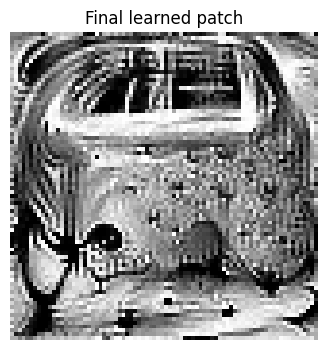

In [ ]:
final_patch = patch.detach().cpu()[0]
plt.figure(figsize=(4,4))
plt.imshow(final_patch.permute(1,2,0))
plt.axis('off'); plt.title("Final learned patch"); plt.show()

# Show patched samples
model.eval()
sample_imgs = [train_dataset[i][0] for i in random.sample(range(len(train_dataset)), 6)]
batch = torch.stack(sample_imgs).to(device)
patched_batch = paste_patch_batch(batch, patch)
outs = model(patched_batch)
preds = outs.argmax(1).cpu().tolist()


# Test the patch

In [ ]:
# pick random test images (tensors)
sample_imgs = [train_dataset[i][0] for i in random.sample(range(len(train_dataset)), 6)]
batch = torch.stack(sample_imgs).to(device)


In [ ]:
# Load ImageNet labels for readability
from torchvision.models import ResNet34_Weights
imagenet_labels = ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

# Take a batch of sample images
sample_imgs = [train_dataset[i][0] for i in random.sample(range(len(train_dataset)), 6)]
batch = torch.stack(sample_imgs).to(device)

# Model predictions before patch
model.eval()
with torch.no_grad():
    outputs_clean = model(batch)
    preds_clean = outputs_clean.argmax(1).cpu().tolist()

# Apply patch and predict again
patched_batch = paste_patch_batch(batch, patch)
with torch.no_grad():
    outputs_patched = model(patched_batch)
    preds_patched = outputs_patched.argmax(1).cpu().tolist()

# Compare results
for i in range(len(preds_clean)):
    clean_label   = imagenet_labels[preds_clean[i]]
    patched_label = imagenet_labels[preds_patched[i]]
    print(f"Image {i+1}: clean → {clean_label:20s} | patched → {patched_label:20s}")


Image 1: clean → torch                | patched → cradle              
Image 2: clean → Petri dish           | patched → pencil sharpener    
Image 3: clean → toilet seat          | patched → pencil sharpener    
Image 4: clean → candle               | patched → toaster             
Image 5: clean → hoopskirt            | patched → toaster             
Image 6: clean → yawl                 | patched → toaster             


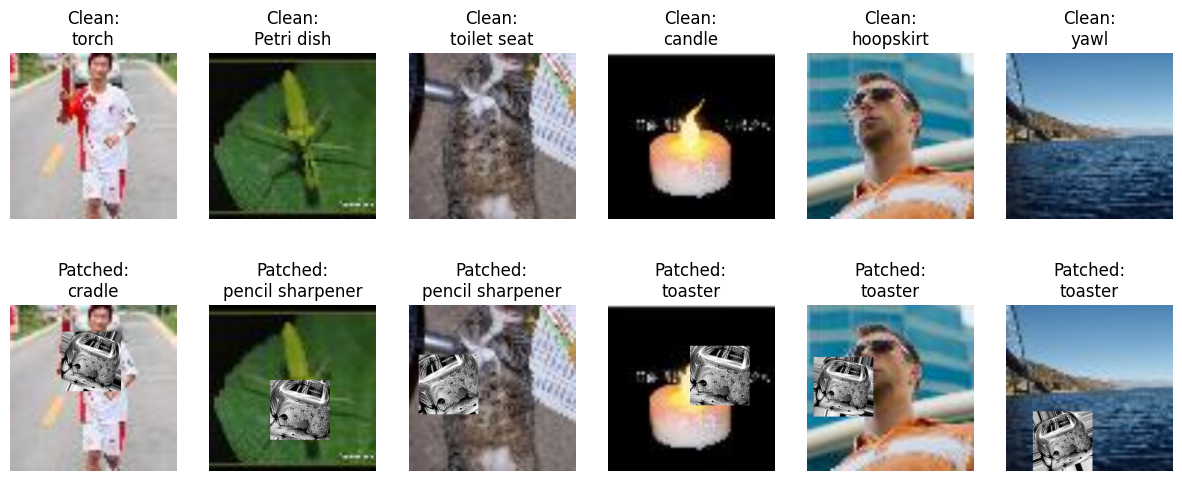

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(15,6))
for idx in range(6):
    axs[0, idx].imshow(batch[idx].cpu().permute(1,2,0).detach())
    axs[0, idx].set_title(f"Clean:\n{imagenet_labels[preds_clean[idx]]}")
    axs[0, idx].axis('off')

    axs[1, idx].imshow(patched_batch[idx].detach().cpu().permute(1,2,0))
    axs[1, idx].set_title(f"Patched:\n{imagenet_labels[preds_patched[idx]]}")
    axs[1, idx].axis('off')
plt.show()
